In [6]:
%pip install wheel

Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install tensorflow matplotlib tensorflow-datasets ipywidgets

  Using cached tensorflow-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (3.6 kB)
  Using cached matplotlib-3.8.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached tensorflow_datasets-4.9.4-py3-none-any.whl.metadata (9.2 kB)
  Using cached ipywidgets-8.1.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached tensorflow_macos-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.2 kB)
  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.10.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (2.5 kB)
  Using cached libclang-16.0.6-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached numpy-1.26.2-cp311-c

In [8]:
%pip install tensorflow-metal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.3 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


## Dataset

In [11]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [24]:
ds = tfds.load('uc_merced', split='train', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2100 [00:00<?, ? examples/s]

Shuffling /Users/ishaandey/tensorflow_datasets/uc_merced/2.0.0.incompleteLYQZAQ/uc_merced-train.tfrecord*...: …

Dataset uc_merced downloaded and prepared to /Users/ishaandey/tensorflow_datasets/uc_merced/2.0.0. Subsequent calls will reuse this data.


In [25]:
ds.as_numpy_iterator().next()

{'filename': b'harbor22.tif',
 'image': array([[[ 16,  18,  15],
         [  2,   5,   3],
         [  2,   7,   4],
         ...,
         [ 58,  54,  65],
         [123, 118, 129],
         [190, 185, 194]],
 
        [[  2,   4,   2],
         [  1,   3,   0],
         [  0,   4,   1],
         ...,
         [ 48,  42,  53],
         [126, 120, 132],
         [198, 192, 202]],
 
        [[  1,   3,   0],
         [  3,   7,   2],
         [  3,   8,   3],
         ...,
         [ 45,  41,  51],
         [119, 115, 126],
         [186, 182, 191]],
 
        ...,
 
        [[122, 126, 113],
         [113, 117, 105],
         [104, 108,  97],
         ...,
         [172, 171, 167],
         [181, 179, 177],
         [195, 194, 194]],
 
        [[180, 184, 169],
         [174, 178, 164],
         [169, 173, 160],
         ...,
         [104,  99,  96],
         [115, 109, 107],
         [131, 126, 126]],
 
        [[195, 199, 184],
         [195, 199, 184],
         [197, 201, 186],
   

In [26]:
import numpy as np

In [27]:
dataiterator = ds.as_numpy_iterator()

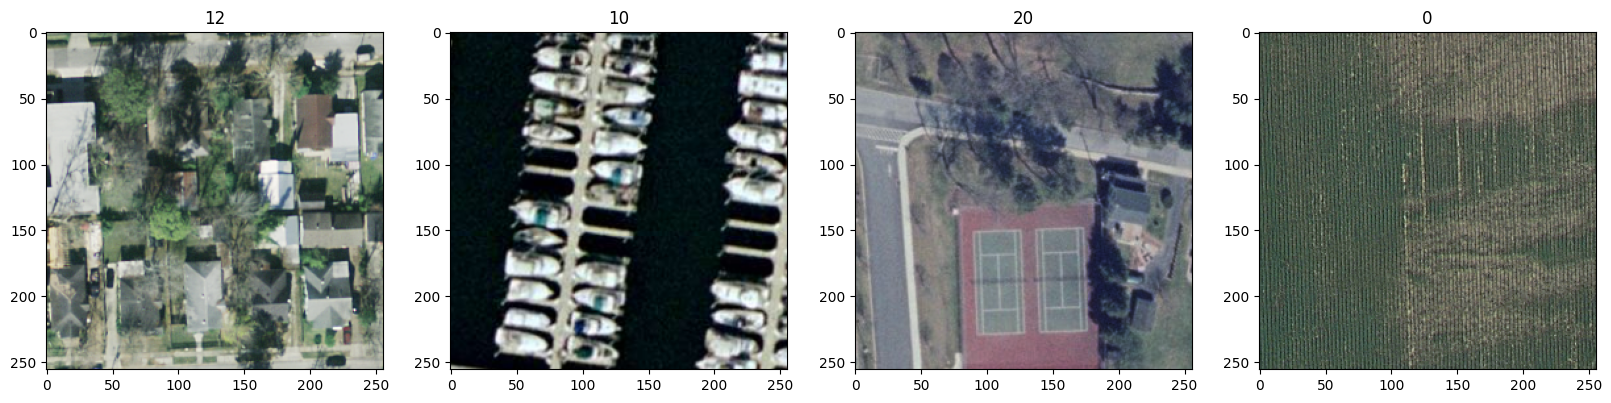

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 20))

for i in range(4):
    sample = dataiterator.next()   
    ax[i].imshow(sample['image'])
    ax[i].set_title(sample['label'])
  

In [38]:
def scale(data):
    image = data['image']
    image = tf.cast(image, tf.float32)
    return image / 255

In [39]:
ds = tfds.load('uc_merced', split='train')

#preprocessing
ds = ds.map(scale)
ds = ds.cache()
ds = ds.shuffle(2100)
ds = ds.batch(32)
ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

## Generator

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Reshape, LeakyReLU, UpSampling2D

In [91]:
def build_generator():
  model = Sequential()

  model.add(Dense(8*8*256, input_shape=(100,)))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((8, 8, 256)))

  #upsample
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  #upsample
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  #upsample
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  #conv block
  model.add(Conv2D(128, kernel_size=3, padding='same'))
  model.add(LeakyReLU(0.2))

  #conv block
  model.add(Conv2D(128, kernel_size=3, padding='same'))
  model.add(LeakyReLU(0.2))

  #layer to produce 1 channel

  model.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

  return model

In [95]:
generator = build_generator()

In [96]:
generator.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 16384)             1654784   
                                                                 
 leaky_re_lu_62 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_16 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 up_sampling2d_26 (UpSampli  (None, 16, 16, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 16, 16, 128)       524416    
                                                                 
 leaky_re_lu_63 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                     

In [134]:
img = generator(np.random.randn(4, 100, 1))

In [135]:
img.shape

TensorShape([4, 64, 64, 1])

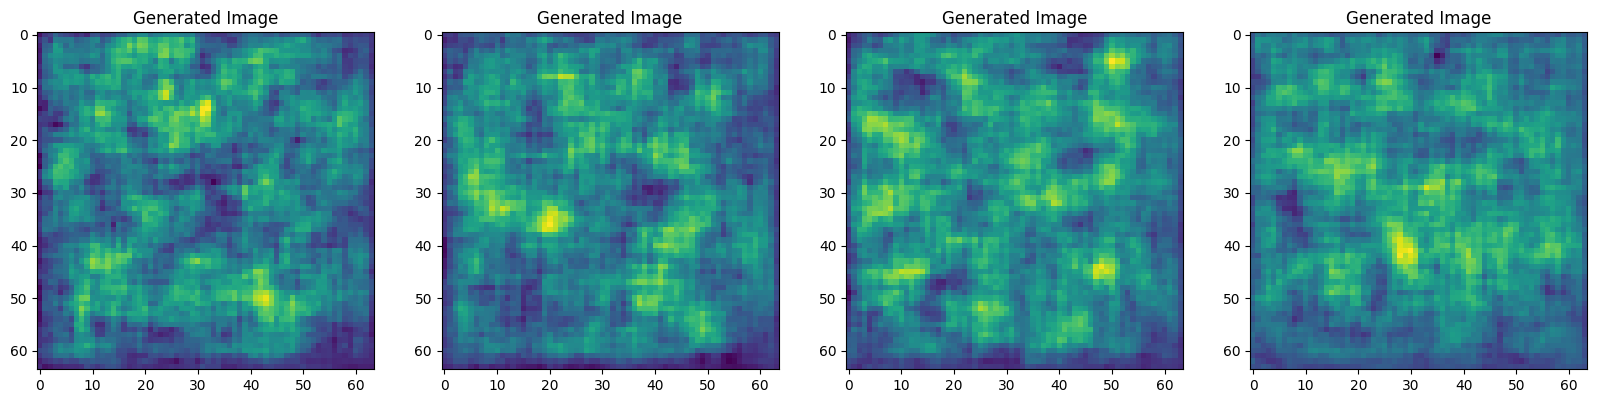

In [126]:
fig, ax = plt.subplots(1, 4, figsize=(20, 20))

# generate 4 images

img = generator(np.random.randn(4, 100, 1))

# img = generator(np.random.randn(1, 100)).numpy().squeeze()
# for i in range(4):
#     ax[i].imshow(img)
#     ax[i].set_title('Generated Image')

for idx, img in enumerate(img):
    ax[idx].imshow(img)
    ax[idx].set_title('Generated Image')


In [133]:
img.shape

TensorShape([64, 64, 1])

## Discriminator

In [127]:
def build_discriminator():
  model = Sequential()

  model.add(Conv2D(32, kernel_size=3, input_shape=(64, 64, 1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Conv2D(64, kernel_size=3, strides=2))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Conv2D(128, kernel_size=3, strides=2))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Conv2D(256, kernel_size=3, strides=2))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [128]:
discriminator = build_discriminator()

In [129]:
discriminator.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 leaky_re_lu_73 (LeakyReLU)  (None, 62, 62, 32)        0         
                                                                 
 dropout_6 (Dropout)         (None, 62, 62, 32)        0         
                                                                 
 conv2d_66 (Conv2D)          (None, 30, 30, 64)        18496     
                                                                 
 leaky_re_lu_74 (LeakyReLU)  (None, 30, 30, 64)        0         
                                                                 
 dropout_7 (Dropout)         (None, 30, 30, 64)        0         
                                                                 
 conv2d_67 (Conv2D)          (None, 14, 14, 128)     

In [137]:
discriminator.predict(img)

1/1 [==============================] - 0s 459ms/step


array([[0.5077147],
       [0.5076563],
       [0.5077355],
       [0.5076379]], dtype=float32)

## Training Loop

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy  

In [ ]:
gen_opt = Adam(learning_rate=0.0001)
dis_opt = Adam(learning_rate=0.00001)

dis_loss = BinaryCrossentropy()
gen_loss = BinaryCrossentropy()

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
class GAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)

    self.generator = generator
    self.discriminator = discriminator

  def compile(self, gen_opt, dis_opt, gen_loss, dis_loss, *args, **kwargs):

    super.compile(*args, **kwargs)
    self.gen_opt = gen_opt
    self.dis_opt = dis_opt
    self.gen_loss = gen_loss
    self.dis_loss = dis_loss

  def train(self, batch):

    real_images = batch
    fake_images = self.generator(tf.random.normal(shape=(32, 100, 1)))

    with tf.GradientTape() as d_tape:
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      noise_real = 0.15 * tf.random.normal(shape=yhat_real.shape)
      noise_fake = -0.15 * tf.random.normal(shape=yhat_fake.shape)
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      d_loss = self.dis_loss(y_realfake, yhat_realfake)

    d_grad = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.dis_opt.apply_gradients(zip(d_grad, self.discriminator.trainable_variables))
